In [41]:
%matplotlib inline
import numpy as np
import pandas as pd
from uncertainties import ufloat
from uncertainties.umath import *  # sin(), etc.
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, NullFormatter
import matplotlib.gridspec as gridspec
import sys
sys.path.append("..")
from exotop.useful_and_bespoke import hide_log_ticklabels, not_iterable, dark_background

M_E = 5.972e24 # kg, Earth mass
M_J = 1.898e27 # kg, Jupiter mass
R_E = 6371e3 # m
R_J = 69911e3 # m
R_sun = 696340e3
AU = 1.495978707e11
L_E = 1.3608e3  # solar constant Wm^-2


In [43]:
# plot known exoplanets from exoplanet.eu

def plot_known_planets(x_name, y_name, fname='exoplanet.eu_catalog.csv', 
                       fpath='/home/claire/Documents/science-docs/planet-data-misc/exoplanet.eu/', 
                       fig=None, ax=None, showerror=False, save=False,
                       M_s_min=0.85, M_s_max=1.15, det_method='Transit', 
                       xscale=1, yscale=1, ticksize=20,
                       labelc = 'xkcd:off white', ax_fc='xkcd:black', fc='xkcd:eggshell blue', 
                       titlesize=55, axissize=30, ylim=[0.5, 6], xlim=[1e-2, 10], 
                       xlabel='Semi-major axis (AU)', ylabel=r'Planetary radius (R$_E$)',
                       xticks=None, yticks=[0.5, 1, 1.75, 3.5, 6], include_ss=True, 
                       y2label=None, y2ticks=None, y2ticklabels=None,
                       ffmt='.png', figname='exo_known', figpath='figs/', ylabelpad=15, xlabelpad=15,
                       planet_icon_path='/home/claire/Pictures/science-graphics/planet_png/'):
    from matplotlib.ticker import FormatStrFormatter
    from exotop.useful_and_bespoke import imscatter, colorize

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 9))
    
    file = fpath + fname
    df = pd.read_csv(file)
    
    # extra derived quantities
    if 't_eq' in [x_name, y_name]:
        T_s = df.star_teff
        a = df.semi_major_axis*AU
        R_s = df.star_radius*R_sun
        A_b = 0
        df['t_eq'] =  T_s * np.sqrt(R_s/(2*a)) * (1 - A_b)**0.25
    if 'instellation' in [x_name, y_name]:
        T_s = df.star_teff
        a = df.semi_major_axis*AU
        R_s = df.star_radius*R_sun
        L_s = 4*np.pi*R_s**2*5.67e-8*T_s**4
        df['instellation'] = L_s/(4*np.pi*a**2)  
        a_err_min = df.semi_major_axis_error_min*AU
        a_err_max = df.semi_major_axis_error_max*AU
        df['instellation_error_min'] = L_s/(4*np.pi*a_err_min**2)  
        df['instellation_error_max'] = L_s/(4*np.pi*a_err_max**2) 
    
    # filter
    df.dropna(axis=0, how='any', subset=[x_name, y_name], inplace=True)
    sp_type = df.star_sp_type.astype(str)
    if M_s_min is not None:
        cond1 = df.star_mass > M_s_min
        cond2 = df.star_mass < M_s_max
        df = df[cond1 & cond2]
    if det_method is not None:
        cond = df.detection_type == det_method
        df = df[cond]
            
    y = df[y_name].to_numpy()*yscale
    x = df[x_name].to_numpy()*xscale

    if showerror:
        try:
            yerr = np.vstack([df[y_name + '_error_min'].to_numpy(), df[y_name + '_error_max'].to_numpy()])*yscale
        except KeyError:
            yerr = None
        try:
            xerr = np.vstack([df[x_name + '_error_min'].to_numpy(), df[x_name + '_error_max'].to_numpy()])*xscale
        except KeyError:
            xerr = None
        markers, caps, bars = ax.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='.', mfc=fc, ms=20, mew=0,
                                         alpha=0.5, elinewidth=2, ecolor=fc,
                                         )
#         [m.set_alpha(0.5) for m in markers]
    else:
        ax.plot(x, y, '.', markersize=20, alpha=0.5, color=fc)

    print('N planets =',len(df))

    if include_ss:
        df_ss = pd.read_csv('/home/claire/Documents/science-docs/planet-data-misc/solar_system_facts.csv',
                           index_col=0)
        x_ss = df_ss.loc[x_name].astype(float)
        y_ss = df_ss.loc[y_name].astype(float)
        for pl in ['Mercury', 'Venus', 'Earth', 'Moon', 'Mars', 'Ceres', 'Jupiter', 'Saturn', 
                   'Uranus', 'Neptune', 'Pluto']:
            imscatter(x_ss[pl], y_ss[pl], planet_icon_path + pl + '.png', zoom=0.08, ax=ax)

    if ylim is not None:
        ax.set_ylim(ylim) 
    if xlim is not None:
        ax.set_xlim(xlim)
    ax.set_xscale('log')
    ax.set_yscale('log')
#     ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.set_xlabel(xlabel, fontsize=axissize, labelpad=xlabelpad)
    ax.set_ylabel(ylabel, fontsize=axissize, labelpad=ylabelpad)

    if yticks is not None:
        ax.set_yticks(yticks)
    if xticks is not None:
        ax.set_xticks(xticks)
    ax.tick_params(axis='x', labelsize=ticksize, pad=15)
    ax.tick_params(axis='y', labelsize=ticksize, pad=15)

    fig, ax = dark_background(fig, ax)
    
    if y2label is not None:
        ax2 = ax.twinx()
        ax2.set_ylabel(y2label, fontsize=axissize, labelpad=ylabelpad*10, rotation=270)
        ax2.set_yscale('log')
        ax2.set_ylim(ax.get_ylim())
        ax2.set_yticks(y2ticks)
        ax2.set_yticklabels(y2ticklabels)
        ax2.tick_params(axis='y', colors=labelc, labelsize=ticksize, pad=15)
        fig, ax2 = dark_background(fig, ax2)
    

    if save:
        fig.savefig(figpath + figname + ffmt, bbox_inches='tight', dpi=200, facecolor=fig.get_facecolor())
    return fig, ax

N planets = 877


(<Figure size 720x648 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa103611c90>)

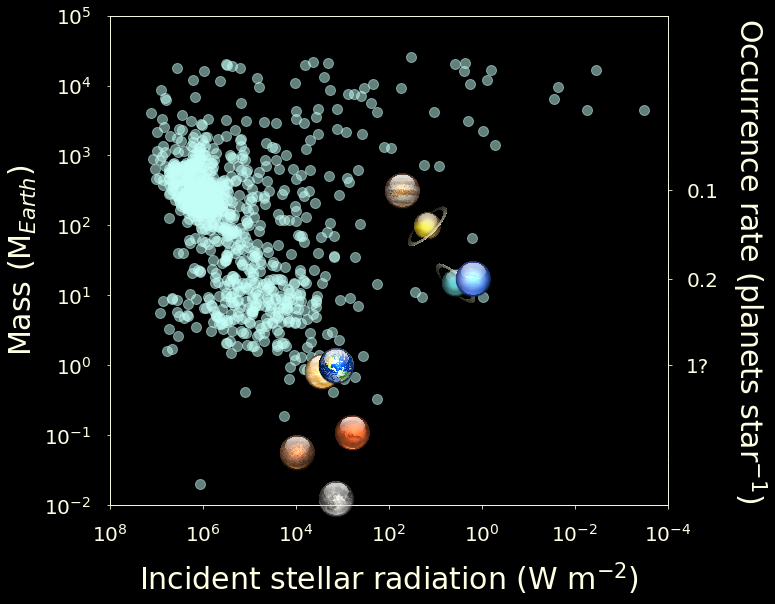

In [44]:
fig, ax = plot_known_planets('instellation', 'mass', fname='exoplanet.eu_catalog.csv', showerror=False,
                   fpath='/home/claire/Documents/science-docs/planet-data-misc/exoplanet.eu/', 
                   xlabel=r'Incident stellar radiation (W m$^{-2}$)', ylabel=r'Mass (M$_{Earth}$)', 
                   yscale=M_J/M_E, #xscale=1/L_E,
                   det_method=None, M_s_min=None, M_s_max=None, ylabelpad=5,
                       titlesize=55, axissize=30, ylim=[1e-2, 1e5], xlim=[1e8, 1e-4], 
                       xticks=None, yticks=None, include_ss=True,
                  y2label=r'Occurrence rate (planets star$^{-1}$)', y2ticks=[1, 17.15, M_J/M_E], y2ticklabels=['1?', '0.2', '0.1'],
                       figname='exo_known_ss_occ', save=True
                  )

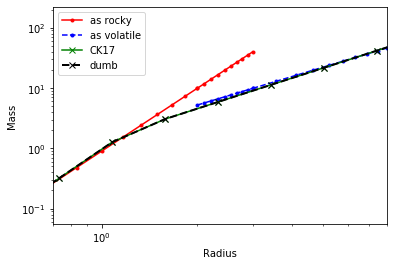

In [113]:
def M_R(R, which='rocky', author='ChenKipping', Mb=5, Rb=None):
    if not_iterable(R):
        R = [R]
    if author == 'ChenKipping':
        # at worst this will slightly underestimate mass around 5 M_E
        c1 = 1.01
        a1 = 0.28
        c2 = 0.82
        a2 = 0.59
        Rb = c1*(2**a1)
        return np.array([(x/c1)**(1/a1) if x < Rb else (x/c2)**(1/a2) for x in R])
    elif author == 'Otegi':
        # otegi+ 2020 is too weird and not useable for analytic shit
        if which == 'rocky':
            return 0.9*np.array(R)**3.45
        elif which == 'volatile':
            return 1.74*np.array(R)**1.58
        else:
            raise Exception('must be rocky or volatile')
    else:
        # use a stupid one where planets are rocky til given M_E and there's a sudden discontinuity
        # chen and kipping fit is so close it just misses extended rocky mass range
        c1 = 1.01
        a1 = 0.28
        c2 = 0.82
        a2 = 0.59
        if (Rb is None) and (Mb is not None):
            Rb = c1*(Mb**a1)
        elif Rb is None:
            raise Exception('Both R and M break cannot be None')
        return np.array([(x/c1)**(1/a1) if x < Rb else (x/c2)**(1/a2) for x in R])

R_lo = np.linspace(0.5, 2, num=10)
R_hi = np.linspace(3, 8, num=10)
plt.plot(R_lo, M_R(R_lo, 'rocky', author='Otegi'), '.-', c='r')
plt.plot(R_hi, M_R(R_hi, 'volatile', author='Otegi'), '.--', c='b')
plt.xlabel('Radius')
plt.ylabel('Mass')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
    
R = np.linspace(2, 3, num=10)
M_asrock = M_R(R, 'rocky', author='Otegi')
M_asvol = M_R(R, 'volatile', author='Otegi')

plt.plot(R, M_asrock, '.-', label='as rocky', c='r')
plt.plot(R, M_asvol, '.--', label='as volatile', c='b')

R = np.logspace(np.log10(0.5), np.log10(16), num=10)
plt.plot(R, M_R(R, author='ChenKipping'), 'x-', label='CK17', c='g')
plt.plot(R, M_R(R, author=None, Rb=1.5), 'x--', label='dumb', c='k', lw=2)
plt.xlim([0.7, 8])

plt.legend()

# need to avoid problems with non-monotonic - absolutely essential for ur literal purposes -  from their fig 1 it looks like  lots of RV dots above 5 ME that are above Earth-like composition line - therefore significant water ice and seems sketchy to say 63% of planets at 3RE are rocky, e.g.
plt.figure()
R = [ 0.5,   0.75 , 1.  ,  1.25  ,1.5  , 1.75 , 2.  ,  2.5 ,  3.  ,  4.  ,  6. ,   8., 12.  , 16.  ]
M = M_R(R, author=None, Rb=1.5)
plt.plot(M, R, 'x-', c='k')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

PDF domain 0.08118193428350123 153.8011358540565


/home/claire/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


ValueError: too many values to unpack (expected 2)

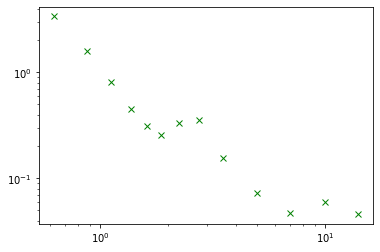

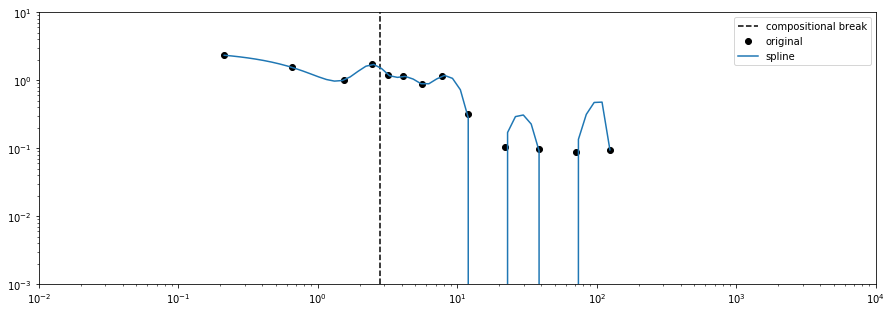

In [206]:
def pdf_from_file(fname, fpath='', scale=1, margin_ax=1, radiustomass=False, R_break=1.5, c='k',
                 domain_min=None, domain_max=None, plot=False, fig=None, MR_name='custom', funits=None):
    from scipy.interpolate import UnivariateSpline, splrep, splev, interp1d
    # margin_ax = 1 to marginalise over cols
    file = fpath + fname
    if margin_ax is not None:
        df = pd.read_csv(file, index_col=0, comment='#')
        df['total'] = df.sum(axis=margin_ax)
        x = df.index.to_numpy()
        x = np.flip(x)
        f = df.total.to_numpy()[:-1]*scale
        f = np.flip(f)

    else:
        df = pd.read_csv(file, index_col=False, comment='#')
        if ('R' in df.columns) and not ('M' in df.columns):
            if not radiustomass:
                raise Exception('should probably use M-R relation for this input file')
            df.sort_values(by=['R'], inplace=True)
            x = df.R.to_numpy()
        else:
            df.sort_values(by=['M'], inplace=True)
            x = df.M.to_numpy()
        f = df.f.to_numpy()*scale
    
    plt.figure()
    plt.plot((x[1:] + x[:-1]) / 2, f, 'gx')
    plt.gca().set_xscale('log')
    plt.gca().set_yscale('log')
    
    
    if radiustomass:
        R = x
        if MR_name == 'Otegi':
            # find transitions
            i_tr_min = np.argmax(R >= 2)
            i_tr_max = np.argmax(R >= 3)
            R_rock = R[:i_tr_min]
            R_trans = R[i_tr_min:i_tr_max]
            R_vol = R[i_tr_max:]
            N_rock = f[:i_tr_min]
            N_trans = f[i_tr_min:i_tr_max]
            N_vol = f[i_tr_max:]

            # convert original radius ranges to mass
            M_rock = M_R(R_rock, 'rocky', author='Otegi')
            M_vol = M_R(R_vol, 'volatile', author='Otegi')
            M_trans = np.array([0.63*M_R(r, 'rocky', author='Otegi') + (1 - 0.63)*M_R(r, 'volatile', author='Otegi') for r in R_trans])
            M = np.concatenate((M_rock, M_trans, M_vol), axis=None)
        elif MR_name == 'custom':
            M = M_R(R, author=None, Rb=R_break)  # custom transition
            R_rock = R[R < R_break]
            R_trans = []
            R_vol = R[R >= R_break]
            
        if funits is 'perlnR':
            df2 = pd.DataFrame({'M':M, 'R':R})
            df2['class'] = ['rocky']*(len(R_rock)) + ['trans']*len(R_trans) + ['volatile']*(len(R_vol))
            df2['f_lnR'] = f
            df2['f_lnM'] = np.concatenate((0.28*f[R < R_break], 0.59*f[R >= R_break]), axis=None)            
        elif funits is None:
            df2 = pd.DataFrame({'M_min':M[:-1], 'M_max':M[1:], 'R_min':R[:-1], 'R_max':R[1:]})
            df2['class'] = ['rocky']*(len(R_rock)) + ['trans']*len(R_trans) + ['volatile']*(len(R_vol) - 1)
            df2['N'] = f 
            df2['f_lnM'] = df2.N / np.log(df2.M_max.astype(float)/df2.M_min.astype(float))  # occurrence per delta(lnM)
            df2.index.name = 'bin'
        fM = df2.f_lnM.to_numpy()
#         print(df2.head())
        
        # get rid of awkward high end of transitionl masses - probably gaseous
        i_bad = np.where(fM < 0)[0]
        fM = np.delete(fM, i_bad)
        M = np.delete(M, i_bad)
        if not (not i_bad):
            print('removed values at i =', i_bad)

        x = M
        f = fM

    print('PDF domain', np.min(x), np.max(x))
    if len(x) == len(f) + 1:
        x_mids = (x[1:] + x[:-1]) / 2  # take midpoint
    else:
        x_mids = x
    if domain_min is None:
        domain_min = np.min(x_mids)
    if domain_max is None:
        domain_max = np.max(x_mids)

    xhat = np.logspace(np.log10(domain_min), np.log10(domain_max))
    
    try:
        spl = splrep(x_mids, f, k=3, s=0)  # spline
    except Exception as e:
        print('x_mids', 'N=',len(x_mids))
        print('f','N=',len(f))
        i = np.argwhere(np.diff(x_mids) < 0)[0]
        print('M is not increasing at index', i, '...try another R_break?')
        i = i[0]
        print('M[i-1:i+2]',M[i-1:i+2])
        print('R[i-1:i+2]',R[i-1:i+2])
        raise e
    yhat = splev(xhat, spl)
    
    if plot:
        if fig is None:
            fig = plt.figure(figsize=(15,5))
        if R_break is not None:
            plt.axvline(x=M_R(R_break, author=None, Rb=R_break), label='compositional break', ls='--', c='k')
        plt.plot(x_mids, f, 'o', label='original',c=c)  # original
        plt.gca().set_xscale('log')
        plt.gca().set_yscale('log')
        plt.plot(xhat, yhat, label='spline')
        plt.xlim(1e-2, 1e4)
        plt.ylim(1e-3, 10)
        plt.legend()
        return xhat, yhat, fig

    return xhat, yhat


u, pdf = pdf_from_file('occurrence-rates-hsu2019.csv',fpath='/home/claire/Documents/science-docs/planet-data-misc/', 
                       plot=True, radiustomass=True, scale=0.01)

# _, _, fig = pdf_from_file('fake_occurrence_pdf_hsu.csv',fpath='/home/claire/Documents/science-docs/planet-data-misc/', 
#                        scale=0.4, margin_ax=None, plot=True, c='b')

# _, _, fig = pdf_from_file('gils_mulders.csv',fpath='/home/claire/Documents/science-docs/planet-data-misc/', 
#                        radiustomass=True, scale=1, margin_ax=None, plot=True, funits='perlnR',
#                       R_break=1.3, c='g', fig=fig)

N planets = 877


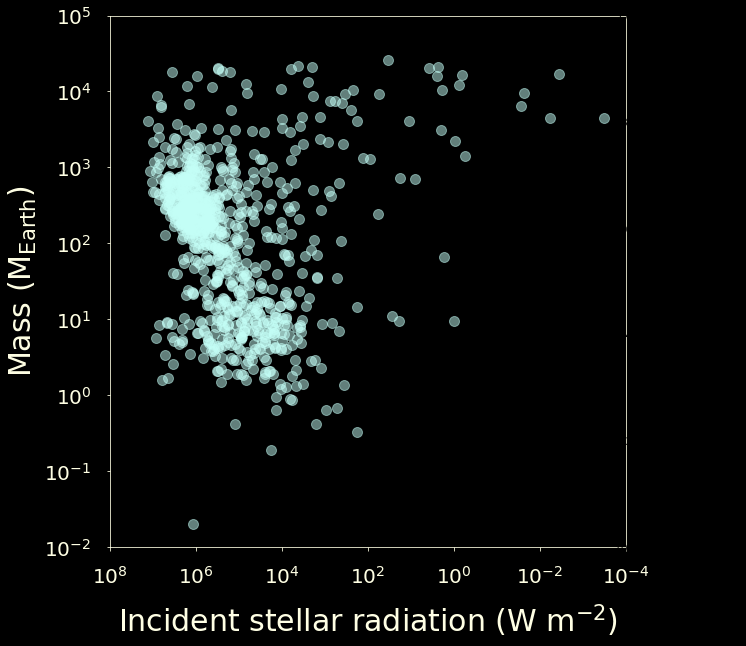

In [203]:
def add_axes_pdf(fig=None, ax=None, orientation='y', lw=3, c='xkcd:off white',
                 labelc='xkcd:off white', ax_fc='xkcd:black', fc='xkcd:eggshell blue', 
                 axissize=30, ticksize=20, pdflim=[2e-2, 3], ulim=[0.625, 14.0], xlabelpad=15, ylabelpad=15,
                 pdfticks=[1e-1, 1], uticks=[], pdf_csv='fake_occurrence_pdf_hsu.csv',
                 label=r'$\frac{N_{\mathrm{planets}}}{\ln(M)\;\mathrm{star}}$', title='',
                 fpath='/home/claire/Documents/science-docs/planet-data-misc/', pdf_fudge=1):
    
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_xscale('log')
    ax.set_yscale('log')
        
    u, pdf = pdf_from_file(pdf_csv,fpath=fpath, margin_ax=None, scale=pdf_fudge)
    u2, pdf2 = pdf_from_file('gils_mulders.csv',fpath=fpath, 
                       radiustomass=True, scale=1, margin_ax=None, funits='perlnR', R_break=1.3)
    
    if orientation == 'y':
        x = pdf
        y = u
        xlabel = label
        ylabel = title
        xticks = pdfticks
        yticks = uticks
        xlim = pdflim
        ylim = ulim
        ax.grid(c=c, axis='x', alpha=0.5)
        ax.yaxis.set_label_position('right') 
#         ax.xaxis.set_label_position('top') 
#         ax.xaxis.tick_top()
    elif orientation == 'x':
        y = pdf
        x = u
        ylabel = label
        xlabel = title
        yticks = pdfticks
        xticks = uticks
        ylim = pdflim
        xlim = ulim
        ax.grid(c=c, axis='y')
        ax.yaxis.set_label_position('right') 
        ax.yaxis.tick_right()
        
    ax.plot(x, y, c=c, lw=lw)
#     ax.plot(pdf2, u2, c=c, lw=1, ls='--')
    
    if ylim is not None:
        ax.set_ylim(ylim) 
    if xlim is not None:
        ax.set_xlim(xlim)
    ax.set_yticks(yticks)
    ax.set_xticks(xticks)
    ax.set_xlabel(xlabel, fontsize=axissize*1, labelpad=xlabelpad)
    ax.set_ylabel(ylabel, fontsize=axissize, labelpad=ylabelpad, rotation=270)
    ax.tick_params(axis='x', labelsize=ticksize, pad=15)
    ax.tick_params(axis='y', labelsize=ticksize, pad=15)
    return fig, ax

def plot_known_planets_occurrence(axratio=3, save=True, addpdf=True, include_ss=True, 
                                  ylim=[1e-2, 1e5], xlim=[1e8, 1e-4], 
                                  titlesize=55, axissize=30, ticksize=20, pdf_fudge=1, wspace=0.075,
                                 ffmt='.png', figname='exo_known_pdf', figpath='figs/'):
    
    fig = plt.figure(figsize=(11, 9), constrained_layout=False)
    gs = fig.add_gridspec(nrows=1, ncols=axratio, wspace=wspace)
    ax1 = fig.add_subplot(gs[:-1])
    ax2 = fig.add_subplot(gs[-1])
    
    fig, ax1 = plot_known_planets('instellation', 'mass', fname='exoplanet.eu_catalog.csv', showerror=False,
                   fpath='/home/claire/Documents/science-docs/planet-data-misc/exoplanet.eu/', 
                   xlabel=r'Incident stellar radiation (W m$^{-2}$)', ylabel=r'Mass (M$_{\mathrm{Earth}}$)', 
                   yscale=M_J/M_E, #xscale=1/L_E, 
                   det_method=None, M_s_min=None, M_s_max=None, ylabelpad=5,
                       xticks=None, yticks=None, include_ss=include_ss, xlim=xlim, ylim=ylim,
                                  titlesize=titlesize, axissize=axissize,ticksize=ticksize,
                                   save=False, fig=fig, ax=ax1
                  )
    
    if addpdf:
        hide_log_ticklabels(ax1, axis='x', index='last', flipped=True)
        fig, ax2 = add_axes_pdf(fig=fig, ax=ax2, orientation='y', lw=3, c='xkcd:off white',
                     labelc='xkcd:off white', ax_fc='xkcd:black', fc='xkcd:eggshell blue', 
                     axissize=axissize, ticksize=ticksize, #uticks=ax1.get_yticks(),
                                pdflim=[2e-2, 3], ulim=ylim, xlabelpad=15, ylabelpad=50,
                                title=r'Occurrence rate density',
                     label=r'$\frac{N}{\mathrm{d}\ln(M)}$',
                                fpath='/home/claire/Documents/science-docs/planet-data-misc/',
                                pdf_csv='fake_occurrence_pdf_hsu.csv', pdf_fudge=pdf_fudge,
                               )
        fig, ax2 = dark_background(fig, ax2)
    else:
        fig, ax2 = dark_background(fig, ax2, fgc='xkcd:black')
    if save:
        plt.subplots_adjust(left=0.135, right=0.92, bottom=0.15, top=0.97)
        fig.savefig(figpath + figname + ffmt, dpi=200, facecolor=fig.get_facecolor())
   
    
plot_known_planets_occurrence(axratio=6, wspace=0.15, ticksize=20, pdf_fudge=0.4, addpdf=False,
                             figname='exo_known', include_ss=False)